-----------------Config Info-----------------
N: 10
T: 11000
T_train_val: 10000
train_ratio: 0.8
T_train: 8000
T_val: 2000
T_test: 1000
data_type: ar1
batch_size: 64
seq_length: 20
input_size: 10
output_size: 10
learning_rate: 0.001
num_epochs: 100
num_workers: 24
device: cuda
mix_precision: True
patience_epochs: 6
min_delta: 0.01
mode: min
factor: 0.1
patience_lr: 2
min_lr: 1e-06
threshold: 0.01
dg_config:
    mean_load: 50.0
    var_load: 10.0
    iid_var: 1.0
    theta: 0.9
ar_config:
    order: 5
lstm_config:
    hidden_size: 64
    num_layers: 4
gat_config:
    hidden_size: 32
    num_heads: 8
    num_gat_layers: 3
gnn_config: GNNConfig(hidden_size=32, num_layers=3)
-----------------Train and Valid Data Info-----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
data_type: ar1
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
train_val_data_np.shape: (10, 10000

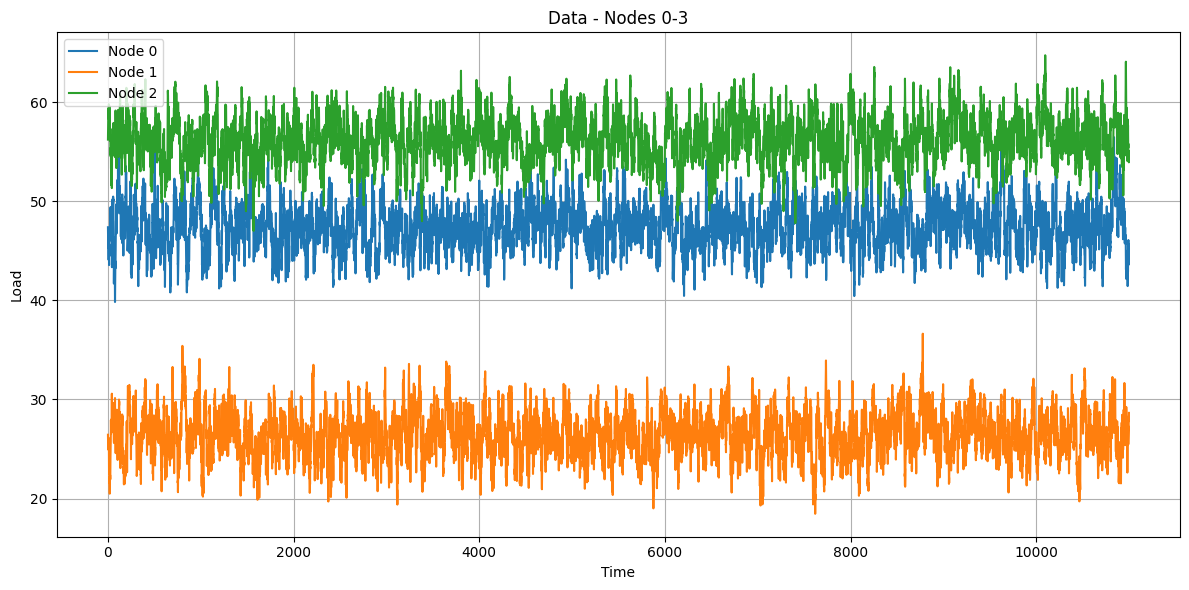

In [1]:
import torch
from Config_Data import DataGenerateConfig, ARConfig, LSTMConfig, GATConfig, GNNConfig, Process

current_config = {
    'N': 10,
    'T': 11000,
    'T_train_val': 10000,
    'T_test': 1000,
    'train_ratio': 0.8,
    'T_train': 8000,
    'T_val': 2000,
    'data_type': 'ar1',

    'batch_size': 64,
    'seq_length': 20,
    'input_size': 10,
    'output_size': 10,
    'learning_rate': 0.001,
    'num_epochs': 100,
    'num_workers': 24,
    'device': 'cuda',

    'patience_epochs': 6,
    'min_delta': 1e-2,

    'mode': 'min',
    'factor': 0.1,
    'patience_lr': 2,
    'min_lr': 1e-6,
    'threshold': 1e-2,

    'dg_config': DataGenerateConfig(mean_load=50.0, var_load=10.0, iid_var=1.0, theta=0.9),
    'ar_config': ARConfig(order=5),
    'lstm_config': LSTMConfig(hidden_size=64, num_layers=4),
    'gat_config': GATConfig(hidden_size=32, num_heads=8, num_gat_layers=3),
    'gnn_config': GNNConfig(hidden_size=32, num_layers=3)
}
# config, data_generate, data_train_val_manage = main(RE_GENERATE_DATA=True, **current_config)

config, data_manage = Process(RE_GENERATE_DATA=False, **current_config)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim.lr_scheduler as lr_scheduler


In [45]:
class ModelExpert:
    def __init__(self, config, data_manage, type):
        self.config = config
        self.data_manage = data_manage
        
        self.type = type
        
        self.device = self.config.device
        self.mix_precision = self.config.mix_precision
        
        self.N = self.config.N
        self.T = self.config.T
        self.T_train_val = self.config.T_train_val
        self.train_ratio = self.config.train_ratio
        self.T_train = self.config.T_train
        self.T_val = self.config.T_val
        self.T_test = self.config.T_test
        
        self.train_val_data_np = self.data_manage.train_val_data_np
        self.train_data_np = self.data_manage.train_data_np
        self.val_data_np = self.data_manage.val_data_np
        self.test_data_np = self.data_manage.test_data_np
        
        self.train_val_data_tensor = self.data_manage.train_val_data_tensor
        self.train_data_tensor = self.data_manage.train_data_tensor
        self.val_data_tensor = self.data_manage.val_data_tensor
        self.test_data_tensor = self.data_manage.test_data_tensor
        
        self.train_val_dataloader = self.data_manage.train_val_dataloader
        self.train_dataloader = self.data_manage.train_dataloader
        self.val_dataloader = self.data_manage.val_dataloader

        self.edge_index = self.data_manage.edge_index_tensor
        
        self.num_epochs = self.config.num_epochs
        self.seq_length = self.config.seq_length
        self.output_size = self.config.output_size
        self.patience_epochs = self.config.patience_epochs
        self.min_delta = self.config.min_delta
        
        if self.type == 'LSTM':
            self.model = self.LSTMModel(
                input_size=self.config.input_size,
                hidden_size=self.config.lstm_config.hidden_size,
                output_size=self.config.output_size,
                num_layers=self.config.lstm_config.num_layers
            ).to(self.device)
        # elif self.type == 'GNN':
        #     self.model = self.GNNModel(
        #         in_channels=self.config.input_size,
        #         hidden_size=self.config.gnn_config.hidden_size,
        #         out_channels=self.config.output_size,
        #         num_layers=self.config.gnn_config.num_layers,
        #         edge_index=self.data_manage.edge_index
        #     ).to(self.device)
        else:
            raise ValueError("Invalid model type. Must be 'LSTM' or 'GNN'.")
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.learning_rate)

        # 初始化调度器
        self.scheduler = lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode=self.config.mode,  # 'min' 表示监控的指标需要最小化
            factor=self.config.factor,  # 每次减少学习率的比例
            patience=self.config.patience_lr,  # 当监控的指标在 patience 个 epoch 内没有改善时减少学习率
            min_lr=self.config.min_lr,  # 学习率的下限
            threshold=config.threshold  # 用于衡量监控指标的阈值，小于该值表示改善不明显
        )

        # 用于记录预测值
        self.train_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
        self.val_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)
        self.test_predictions = torch.zeros((self.T_test, self.output_size), device=self.device)

        # 用于记录损失的列表
        self.train_val_losses = []
        self.train_losses = []
        self.val_losses = []
        self.fine_tune_losses = []
        
        # 用于记录学习率的列表
        self.train_val_learning_rates = []
        self.train_with_val_learning_rates = []
        self.fine_tune_learning_rates = []

        self.epochs_trained = 0  # 用于记录实际训练的 epoch 数

    # class GNNModel(nn.Module):
    #     def __init__(self, in_channels, hidden_size, out_channels, num_layers, edge_index):
    #         super().__init__()
    #         self.get_layers = nn.ModuleList()
    #         
    #         self.edge_index = edge_index.to(self.device)
    #         
    #         self.conv1 = GCNConv(in_channels, hidden_size)
    #         for _ in range(num_layers - 2):
    #             self.get_layers.append(GCNConv(hidden_size, hidden_size))
    #         self.conv2 = GCNConv(hidden_size, out_channels)
    #         self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
    #         self.fc = torch.nn.Linear(out_channels, out_channels)
    # 
    #     def forward(self, x):
    #         x = x.to(self.device)
    #         
    #         # batch_size, seq_len, num_nodes = x.size()
    # 
    #         # Apply GCNConv to each time step individually
    #         x = F.relu(self.conv1(x, self.edge_index))
    #         x = self.conv2(x, self.edge_index)
    # 
    #         # Pass the transformed features through GRU
    #         out, _ = self.rnn(x)
    # 
    #         # Use the last time step's output to predict the next time step's node values
    #         out = self.fc(out[:, -1, :])  # Shape [batch_size, num_nodes]
    #         return out

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers):
            super().__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.layer_norm = nn.LayerNorm(hidden_size)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.lstm(x, (h_0, c_0))
            out = self.layer_norm(out[:, -1, :])
            out = F.relu(out)
            out = self.fc(out)
            return out

    # 定义早停机制类
    class EarlyStopping:
        def __init__(self, patience_epochs=5, min_delta=1e-2):
            # patience: 当验证集损失连续 patience 次没有下降时，停止训练
            # min_delta: 最小的损失下降值，小于该值则不认为损失下降
            
            self.patience_epochs = patience_epochs
            self.min_delta = min_delta
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
    
        def __call__(self, train_loss):
            if self.best_loss is None:
                self.best_loss = train_loss
            elif train_loss < self.best_loss - self.min_delta:
                self.best_loss = train_loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience_epochs:
                    self.early_stop = True

    # def train(self):
    #     scaler = torch.amp.GradScaler(device=self.device) if self.mix_precision else None
    #     early_stopping = self.EarlyStopping(patience_epochs=self.patience_epochs, min_delta=self.min_delta)
    # 
    #     print(f'device: {torch.cuda.get_device_name() if self.device == "cuda" else "CPU"}')
    # 
    #     self.model.train()
    #     for epoch in tqdm(range(self.num_epochs), desc="Training"):
    #         train_cumulative_loss = 0.0  # 训练集累积损失
    # 
    #         for train, val in self.train_val_dataloader:
    #             # 确保数据在 GPU 上，且异步加载
    #             train, val = train.to(self.device, non_blocking=True).float(), val.to(self.device, non_blocking=True).float()
    # 
    #             self.optimizer.zero_grad()  # 梯度清零
    # 
    #             if self.mix_precision:  # 混合精度训练
    #                 with torch.amp.autocast(device_type=self.device):
    #                     if self.type == 'LSTM':
    #                         pred = self.model(train)
    #                     elif self.type == 'GNN':
    #                         pred = self.model(train)  # TODO
    #                     loss = self.criterion(pred, val)
    # 
    #                 scaler.scale(loss).backward()
    #                 scaler.step(self.optimizer)
    #                 scaler.update()
    # 
    #             else:
    #                 if self.type == 'LSTM':
    #                     pred = self.model(train)  # 前向传播
    #                 elif self.type == 'GNN':
    #                     pred = self.model(train)
    #                 loss = self.criterion(pred, val)
    # 
    #                 loss.backward()  # 反向传播
    #                 self.optimizer.step()  # 更新参数
    # 
    #             train_cumulative_loss += loss.item()
    #             self.train_val_losses.append(loss.item())  # 记录单次损失
    # 
    #         # 在每个epoch结束时，计算验证集的平均损失
    #         train_avg_loss = train_cumulative_loss / len(self.train_val_dataloader)
    # 
    #         # 早停机制
    #         early_stopping(train_avg_loss)
    #         if early_stopping.early_stop:
    #             print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
    #             break
    # 
    #         # 调度器更新
    #         self.scheduler.step(train_avg_loss)
    # 
    #         current_lr = self.scheduler.optimizer.param_groups[0]['lr']
    #         self.train_val_learning_rates.append(current_lr)  # 记录学习率
    # 
    #         if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
    #             print(f'Epoch [{epoch + 1}/{self.num_epochs}], Ave_Loss: {train_avg_loss:.4f}')
    #             print(f'Current Learning Rate: {current_lr:.6f}')
    # 
    #             if torch.cuda.is_available():  # 释放GPU缓存
    #                 torch.cuda.empty_cache()
    # 
    #     self.epochs_trained = epoch + 1  # 记录训练的总 epoch 数
    #     print(f"Training finished after {self.epochs_trained} epochs.")
    #     print(f"average loss pre epoch: {train_avg_loss:.4f}")

    def train_with_val(self):
        scaler = torch.amp.GradScaler(device=self.device) if self.mix_precision else None
        early_stopping = self.EarlyStopping(patience_epochs=self.patience_epochs, min_delta=self.min_delta)
    
        print(f'device: {torch.cuda.get_device_name() if self.device == "cuda" else "CPU"}')
    
        self.model.train()
        for epoch in tqdm(range(self.num_epochs), desc="Training"):
            train_cumulative_loss = 0.0  # 训练集累积损失
            val_cumulative_loss = 0.0  # 验证集累积损失
            
            epoch_train_pred = torch.zeros((self.T_train, self.output_size), device=self.device)
            epoch_val_pred = torch.zeros((self.T_val, self.output_size), device=self.device)

            # 累积的起始位置
            train_start_idx = 0
            val_start_idx = 0
            
            # 训练阶段
            self.model.train()  # 确保模型处于训练模式
            for train, val in self.train_dataloader:
                batch_size = train.size(0)
                end_idx = train_start_idx + batch_size
    
                train, val = train.to(self.device, non_blocking=True).float(), val.to(self.device, non_blocking=True).float()
    
                self.optimizer.zero_grad()  # 梯度清零
    
                if self.mix_precision:  # 混合精度训练
                    with torch.amp.autocast(device_type=self.device):
                        if self.type == 'LSTM':
                            train_pred = self.model(train)  # 前向传播, shape: [batch_size, output_size], [64, 10]
                        elif self.type == 'GNN':
                            train_pred = self.model(train)  # TODO
                        train_loss = self.criterion(train_pred, val)

                    scaler.scale(train_loss).backward()
                    scaler.step(self.optimizer)
                    scaler.update()
    
                else:
                    if self.type == 'LSTM':
                        train_pred = self.model(train)  # 前向传播
                    elif self.type == 'GNN':
                        train_pred = self.model(train)
                    train_loss = self.criterion(train_pred, val)
                    train_loss.backward()  # 反向传播
                    self.optimizer.step()  # 更新参数
    
                # 记录训练集预测值
                # epoch_train_pred.append(train_pred.detach().cpu())
                # 将当前批次的预测结果填入对应位置
                epoch_train_pred[train_start_idx:end_idx] = train_pred.detach()
                train_start_idx = end_idx  # 更新起始索引
                
                # T_train = 8000次的累加损失
                train_cumulative_loss += train_loss.item()
                self.train_losses.append(train_loss.item())  # 记录单次训练损失

            # # 将列表中的所有预测结果拼接起来
            # final_epoch_train_pred = torch.cat(epoch_train_pred, dim=0)  # 拼接在第0维，即batch维度
    
            # 验证阶段
            self.model.eval()  # 确保模型处于评估模式
            with torch.no_grad():
                for val_input, val_target in self.val_dataloader:
                    batch_size = val_input.size(0)
                    end_idx = val_start_idx + batch_size
                    
                    val_input, val_target = val_input.to(self.device, non_blocking=True).float(), val_target.to(self.device, non_blocking=True).float()
    
                    if self.mix_precision:  # 混合精度推断
                        with torch.amp.autocast(device_type=self.device):
                            val_pred = self.model(val_input)  # TODO: LSTM/GNN
                            val_loss = self.criterion(val_pred, val_target)
                    else:
                        val_pred = self.model(val_input)
                        val_loss = self.criterion(val_pred, val_target)
                        
                    # # 记录验证集预测值
                    # epoch_val_pred.append(val_pred.detach().cpu())

                    # 将当前批次的预测结果填入对应位置
                    epoch_val_pred[val_start_idx:end_idx] = val_pred.detach()
                    val_start_idx = end_idx  # 更新起始索引
                    
                    # T_val = 2000次的累加损失    
                    val_cumulative_loss += val_loss.item()
                    self.val_losses.append(val_loss.item())  # 记录单次验证损失
                
                # # 将列表中的所有预测结果拼接起来
                # final_epoch_val_pred = torch.cat(epoch_val_pred, dim=0)  # 拼接在第0维，即batch维度
    
            # 计算训练和验证的平均损失
            train_avg_loss = train_cumulative_loss / len(self.train_dataloader)
            val_avg_loss = val_cumulative_loss / len(self.val_dataloader)
    
            # 早停机制基于验证集损失
            early_stopping(val_avg_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered. Stopping training. Epoch: {epoch + 1}")
                break
    
            # 调度器更新基于验证集损失
            self.scheduler.step(val_avg_loss)
    
            current_lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.train_with_val_learning_rates.append(current_lr)  # 记录学习率
    
            if (epoch + 1) % 10 == 0:  # 每10轮输出一次损失, 以及释放GPU缓存
                print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train_Loss: {train_avg_loss:.4f}, Val_Loss: {val_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')
    
                # if torch.cuda.is_available():  # 释放GPU缓存
                #     torch.cuda.empty_cache()
    
        self.epochs_trained = epoch + 1  # 记录训练的总 epoch 数
        print(f"Training finished after {self.epochs_trained} epochs.")
        print(f"Average loss per epoch: {train_avg_loss:.4f}, Validation loss: {val_avg_loss:.4f}")
        
        self.train_predictions = epoch_train_pred
        self.val_predictions = epoch_val_pred
        

    def predict_and_fine_tune(self):
        tune_cumulative_loss = 0.0  # 微调累积损失
        predictions = torch.zeros((self.T_test, self.output_size), device=self.device)

        # 选择训练集的最后一部分数据作为输入
        input_data = self.train_val_data_tensor[:, - self.seq_length:].T.unsqueeze(0).to(self.device)  #  shape: [1, seq_length, input_size], [1, 20, 10]

        for i in tqdm(range(self.T_test), desc="Predicting and Fine-tuning"):
            self.model.train()  # 模型保持在训练模式，以便进行微调
            if self.type == 'LSTM':
                pred = self.model(input_data)  # 预测
            elif self.type == 'GNN':
                pred = self.model(input_data)

            predictions[i] = pred.squeeze(0)  # 将预测值保存到 predictions, shape: [T_test, output_size], [1000, 10]

            loss = self.criterion(pred.squeeze(0), self.test_data_tensor[:, i])  # 计算损失
            tune_cumulative_loss += loss.item()  # 累加损失
            self.fine_tune_losses.append(loss.item())  # 记录单次损失
            
            # 使用真实值进行微调
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # 在每个epoch结束时，计算验证集的平均损失
            tune_avg_loss = tune_cumulative_loss / (i + 1)

            # 调度器更新（可选，基于微调期间的损失）
            self.scheduler.step(tune_avg_loss)
            current_lr = self.scheduler.get_last_lr()[0]
            self.fine_tune_learning_rates.append(current_lr)

            if (i + 1) % 100 == 0:  # 每100步输出一次损失
                print(f'Step {i + 1}/{self.T_test}, Loss: {tune_avg_loss:.4f}')
                print(f'Current Learning Rate: {current_lr:.6f}')

            # 更新输入序列
            # input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(0)), dim=1)
            
            # 更新输入序列
            input_data = torch.cat((input_data[:, 1:, :], self.test_data_tensor[:, i].unsqueeze(1)), dim=1)


# 计算平均损失
        print(f'Average Fine-tuning Loss over {self.T_test} steps: {tune_avg_loss:.4f}')

        self.test_predictions = predictions.detach().cpu().numpy()
        

    # def plot_training_curves(self):
    #     plt.figure(figsize=(12, 8))
    # 
    #     # 绘制训练损失
    #     plt.subplot(3, 1, 1)
    #     plt.plot(self.train_val_losses, label='Training Loss')
    #     plt.plot(range(len(self.train_val_losses), len(self.train_val_losses) + len(self.fine_tune_losses)), self.fine_tune_losses, label='Fine-tuning Loss', color='orange')
    #     plt.axvline(x=len(self.train_val_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
    #     plt.xlabel('Steps')
    #     plt.ylabel('Loss')
    #     plt.title('Loss Over Time')
    #     plt.legend()
    # 
    #     # 绘制累积损失
    #     cumulative_train_loss = [sum(self.train_val_losses[:i + 1]) for i in range(len(self.train_val_losses))]
    #     cumulative_fine_tune_loss = [sum(self.fine_tune_losses[:i+1]) for i in range(len(self.fine_tune_losses))]
    #     plt.subplot(3, 1, 2)
    #     plt.plot(cumulative_train_loss, label='Cumulative Training Loss')
    #     plt.plot(range(len(self.train_val_losses), len(self.train_val_losses) + len(cumulative_fine_tune_loss)), cumulative_fine_tune_loss, label='Cumulative Fine-tuning Loss', color='orange')
    #     plt.axvline(x=len(self.train_val_losses), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
    #     plt.xlabel('Steps')
    #     plt.ylabel('Cumulative Loss')
    #     plt.title('Cumulative Loss Over Time')
    #     plt.legend()
    # 
    #     # 绘制学习率变化
    #     plt.subplot(3, 1, 3)
    #     plt.plot(self.train_val_learning_rates, label='Training Learning Rate')
    #     plt.plot(range(len(self.train_val_learning_rates), len(self.train_val_learning_rates) + len(self.fine_tune_learning_rates)), self.fine_tune_learning_rates, label='Fine-tuning Learning Rate', color='orange')
    #     plt.axvline(x=len(self.train_val_learning_rates), color='r', linestyle='--', label='Training/Fine-tuning Boundary')
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Learning Rate')
    #     plt.title('Learning Rate Over Time')
    #     plt.legend()
    # 
    #     plt.tight_layout()
    #     plt.show()
        
    # def save_training_data(self, file_path):
    #     training_data = {
    #         'train_losses': self.train_val_losses,
    #         'fine_tune_losses': self.fine_tune_losses,
    #         'train_learning_rates': self.train_learning_rates,
    #         'fine_tune_learning_rates': self.fine_tune_learning_rates,
    #         'epochs_trained': self.epochs_trained
    #     }
    #     with open(file_path, 'w') as f:
    #         json.dump(training_data, f)

    def get_prediction_at_time(self, t):
        if t < 0 or t >= self.T_test:
            raise ValueError(f"Time t={t} is out of range. It should be between 0 and {self.T_test-1}.")
        return self.test_predictions[t]

    def plot_full(self):
        plt.figure(figsize=(15, 6))
        # 训练集
        plt.plot(range(self.T_train), self.train_predictions.cpu().numpy(), label='Train Predictions')
        plt.plot(range(self.T_train), self.train_data_np, label='Train Actual')
    
        # 验证集
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_predictions.cpu().numpy(), label='Val Predictions')
        plt.plot(range(self.T_train, self.T_train + self.T_val), self.val_data_np, label='Val Actual')
    
        # 测试集
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_predictions.cpu().numpy(), label='Test Predictions')
        plt.plot(range(self.T_train + self.T_val, self.T_train + self.T_val + self.T_test), self.test_data_np, label='Test Actual')
    
        # 添加竖线
        plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
        plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')
    
        plt.legend()
        plt.title('Full Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()
        
    def plot_train(self):
        plt.figure(figsize=(15, 6))
        plt.plot(self.train_predictions.cpu().numpy(), label='Train Predictions')
        plt.plot(self.train_data_np, label='Train Actual')
    
        plt.legend()
        plt.title('Train Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_val(self):
        plt.figure(figsize=(15, 6))
        # 验证集的预测值和真实值
        plt.plot(self.val_predictions.cpu().numpy(), label='Val Predictions')
        plt.plot(self.val_data_np, label='Val Actual')
    
        plt.legend()
        plt.title('Validation Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_test(self):
        plt.figure(figsize=(15, 6))
        # 测试集的预测值和真实值
        plt.plot(self.test_predictions.cpu().numpy(), label='Test Predictions')
        plt.plot(self.test_data_np, label='Test Actual')
    
        plt.legend()
        plt.title('Test Prediction vs Actual')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_range(self, start, end):
        # 绘制指定范围内的预测值和真实值
        
        # 检查范围是否有效
        if start < 0 or end > (self.T_train + self.T_val + self.T_test) or start >= end:
            raise ValueError(f"Invalid range: start={start}, end={end}. Check the range values.")
    
        plt.figure(figsize=(15, 6))
        
        # 拼接所有数据
        full_data = torch.cat([self.train_predictions, self.val_predictions, self.test_predictions], dim=0).cpu().numpy()
        full_actual = np.concatenate([self.train_data_np, self.val_data_np, self.test_data_np])
    
        # 绘制预测值和真实值
        plt.plot(range(start, end), full_data[start:end], label='Predictions')
        plt.plot(range(start, end), full_actual[start:end], label='Actual')
    
        # 添加竖线
        if start <= self.T_train < end:
            plt.axvline(x=self.T_train, color='black', linestyle='--', label='Train/Val Boundary')
        if start <= self.T_train + self.T_val < end:
            plt.axvline(x=self.T_train + self.T_val, color='black', linestyle='--', label='Val/Test Boundary')
    
        plt.legend()
        plt.title(f'Prediction vs Actual from {start} to {end}')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.show()

    def plot_curves(self):
        fig, axs = plt.subplots(5, 1, figsize=(15, 25))
    
        # 1. 损失steps
        axs[0].plot(self.train_val_losses, label='Train/Val Losses')
        axs[0].axvline(x=len(self.train_val_losses) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
        axs[0].axvline(x=len(self.train_val_losses) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
        axs[0].set_title('Loss over Steps')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
    
        # 2. 损失epochs
        axs[1].plot(range(self.epochs_trained), self.train_losses, label='Train Losses')
        axs[1].plot(range(self.epochs_trained), self.val_losses, label='Val Losses')
        axs[1].set_title('Loss over Epochs')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].legend()
    
        # 3. 累积损失steps
        cumulative_train_val_losses = np.cumsum(self.train_val_losses)
        axs[2].plot(cumulative_train_val_losses, label='Cumulative Train/Val Losses')
        axs[2].axvline(x=len(cumulative_train_val_losses) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
        axs[2].axvline(x=len(cumulative_train_val_losses) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
        axs[2].set_title('Cumulative Loss over Steps')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Cumulative Loss')
        axs[2].legend()
    
        # 4. 累积损失epochs
        cumulative_train_losses = np.cumsum(self.train_losses)
        cumulative_val_losses = np.cumsum(self.val_losses)
        axs[3].plot(range(self.epochs_trained), cumulative_train_losses, label='Cumulative Train Losses')
        axs[3].plot(range(self.epochs_trained), cumulative_val_losses, label='Cumulative Val Losses')
        axs[3].set_title('Cumulative Loss over Epochs')
        axs[3].set_xlabel('Epochs')
        axs[3].set_ylabel('Cumulative Loss')
        axs[3].legend()
    
        # 5. 学习率变化曲线
        axs[4].plot(self.train_val_learning_rates, label='Learning Rate')
        axs[4].axvline(x=len(self.train_val_learning_rates) * self.T_train / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Train/Val Boundary')
        axs[4].axvline(x=len(self.train_val_learning_rates) * (self.T_train + self.T_val) / (self.T_train + self.T_val + self.T_test), color='black', linestyle='--', label='Val/Test Boundary')
        axs[4].set_title('Learning Rate over Training')
        axs[4].set_xlabel('Steps')
        axs[4].set_ylabel('Learning Rate')
        axs[4].legend()
    
        plt.tight_layout()
        plt.show()


    # def get_prediction_at_time(self, t):
    #     if self.train_val_predictions is None:
    #         raise ValueError("You must run predict_and_fine_tune() before accessing predictions.")
    #     return self.train_val_predictions[t], self.test_data_tensor[t]
    # 
    # def plot_full_results(self):
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(self.train_val_predictions[:, 0], label='Predicted')
    #     plt.plot(self.true_values[:, 0], label='True')
    #     plt.xlabel('Time Steps')
    #     plt.ylabel('Load Value')
    #     plt.title('Predicted vs True Load Values for Node 1')
    #     plt.legend()
    #     plt.show()
    # 
    # def plot_val_result(self):
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(self.val_predictions[:, 0], label='Predicted')
    #     plt.plot(self.test_data_tensor[:, 0], label='True')
    #     plt.xlabel('Time Steps')
    #     plt.ylabel('Load Value')
    #     plt.title('Predicted vs True Load Values for Node 1')
    #     plt.legend()
    #     plt.show()
    # 
    # def plot_test_results(self):
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(predictions[:, 0], label='Predicted')
    #     plt.plot(true_values[:, 0], label='True')
    #     plt.xlabel('Time Steps')
    #     plt.ylabel('Load Value')
    #     plt.title('Predicted vs True Load Values for Node 1')
    #     plt.legend()
    #     plt.show()

In [46]:
lstm_expert = ModelExpert(config, data_manage, type='LSTM')

In [47]:
%%time
# lstm_expert.train()

CPU times: total: 0 ns
Wall time: 0 ns


In [48]:
%%time
lstm_expert.train_with_val()

device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  10%|█         | 10/100 [03:29<31:50, 21.22s/it]

Epoch [10/100], Train_Loss: 5.9755, Val_Loss: 5.7751
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [06:57<27:45, 20.81s/it]

Epoch [20/100], Train_Loss: 5.0369, Val_Loss: 5.1956
Current Learning Rate: 0.000100


Training:  28%|██▊       | 28/100 [10:02<25:48, 21.50s/it]

Early stopping triggered. Stopping training. Epoch: 29
Training finished after 29 epochs.
Average loss per epoch: 4.9957, Validation loss: 5.1838
CPU times: total: 22 s
Wall time: 10min 2s


In [49]:
%%time
lstm_expert.predict_and_fine_tune()  # 预测并微调

Predicting and Fine-tuning:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: Tensors must have same number of dimensions: got 3 and 2

ValueError: x and y must have same first dimension, but have shapes (8000,) and (10, 8000)

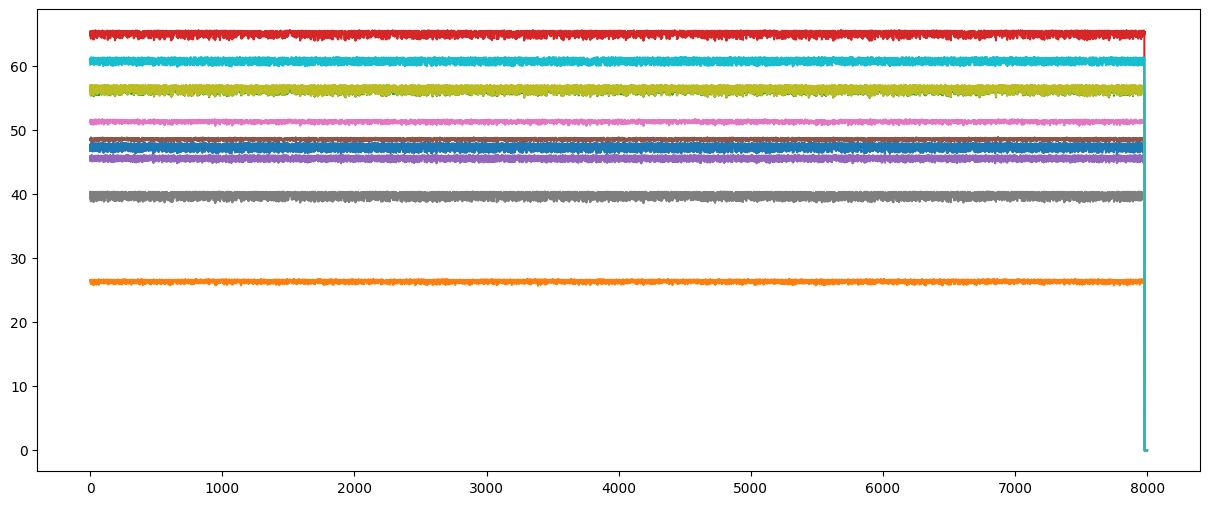

In [50]:
lstm_expert.plot_full()  # 绘制完整预测与真实值对比图

In [ ]:
lstm_expert.plot_train()  # 绘制训练集预测与真实值对比图

In [ ]:
lstm_expert.plot_val()  # 绘制验证集预测与真实值对比图

In [ ]:
lstm_expert.plot_test()  # 绘制测试集预测与真实值对比图

In [ ]:
lstm_expert.plot_range(9000, 11000)  # 绘制指定范围内的预测与真实值对比图

In [ ]:
lstm_expert.plot_curves()  # 绘制训练曲线

In [ ]:
# lstm_expert.plot_training_curves()  # 绘制训练曲线

In [ ]:
# t = 50
# predicted, true_value = lstm_expert.get_prediction_at_time(t)
# print(f"Predicted values for t={t}: {predicted}")
# print(f"True values for t={t}: {true_value}")
# # 绘制预测与真实值对比图
# lstm_expert.plot_results(lstm_expert.train_val_predictions, lstm_expert.true_values)


# GNN

In [10]:
gnn_expert = ModelExpert(config, data_manage, type='GNN')

In [11]:
%%time
gnn_expert.train()

device: NVIDIA GeForce RTX 4060 Laptop GPU


Training:  10%|█         | 10/100 [01:31<15:05, 10.06s/it]

Epoch [10/100], Ave_Loss: 1434.6208
Current Learning Rate: 0.001000


Training:  20%|██        | 20/100 [03:13<13:37, 10.22s/it]

Epoch [20/100], Ave_Loss: 702.9402
Current Learning Rate: 0.001000


Training:  30%|███       | 30/100 [05:07<13:21, 11.45s/it]

Epoch [30/100], Ave_Loss: 282.1971
Current Learning Rate: 0.001000


Training:  40%|████      | 40/100 [07:08<12:00, 12.01s/it]

Epoch [40/100], Ave_Loss: 85.8496
Current Learning Rate: 0.001000


Training:  50%|█████     | 50/100 [08:49<08:22, 10.05s/it]

Epoch [50/100], Ave_Loss: 21.5059
Current Learning Rate: 0.001000


Training:  60%|██████    | 60/100 [10:28<06:31,  9.80s/it]

Epoch [60/100], Ave_Loss: 7.2285
Current Learning Rate: 0.001000


Training:  70%|███████   | 70/100 [12:09<05:04, 10.16s/it]

Epoch [70/100], Ave_Loss: 5.2848
Current Learning Rate: 0.001000


Training:  77%|███████▋  | 77/100 [13:30<04:02, 10.52s/it]

Early stopping triggered. Stopping training. Epoch: 78
Training finished after 78 epochs.
average loss pre epoch: 5.2450
CPU times: total: 29.8 s
Wall time: 13min 30s


In [12]:
%%time
gnn_expert.predict_and_fine_tune()  # 预测并微调

Predicting and Fine-tuning:  14%|█▍        | 140/1000 [00:00<00:04, 190.28it/s]

Step 100/1000, Loss: 5.1119
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  22%|██▏       | 223/1000 [00:01<00:03, 195.82it/s]

Step 200/1000, Loss: 5.3579
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  33%|███▎      | 326/1000 [00:01<00:03, 200.94it/s]

Step 300/1000, Loss: 5.3619
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  43%|████▎     | 429/1000 [00:02<00:02, 197.51it/s]

Step 400/1000, Loss: 5.3598
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  53%|█████▎    | 530/1000 [00:02<00:02, 193.30it/s]

Step 500/1000, Loss: 5.7109
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  63%|██████▎   | 631/1000 [00:03<00:01, 194.18it/s]

Step 600/1000, Loss: 5.5280
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  73%|███████▎  | 732/1000 [00:03<00:01, 194.47it/s]

Step 700/1000, Loss: 5.4588
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  83%|████████▎ | 833/1000 [00:04<00:00, 194.96it/s]

Step 800/1000, Loss: 5.3719
Current Learning Rate: 0.000001


Predicting and Fine-tuning:  93%|█████████▎| 933/1000 [00:04<00:00, 192.39it/s]

Step 900/1000, Loss: 5.2833
Current Learning Rate: 0.000001


Predicting and Fine-tuning: 100%|██████████| 1000/1000 [00:05<00:00, 191.38it/s]

Step 1000/1000, Loss: 5.3411
Current Learning Rate: 0.000001
Average Fine-tuning Loss over 1000 steps: 5.3411
CPU times: total: 1.39 s
Wall time: 5.24 s


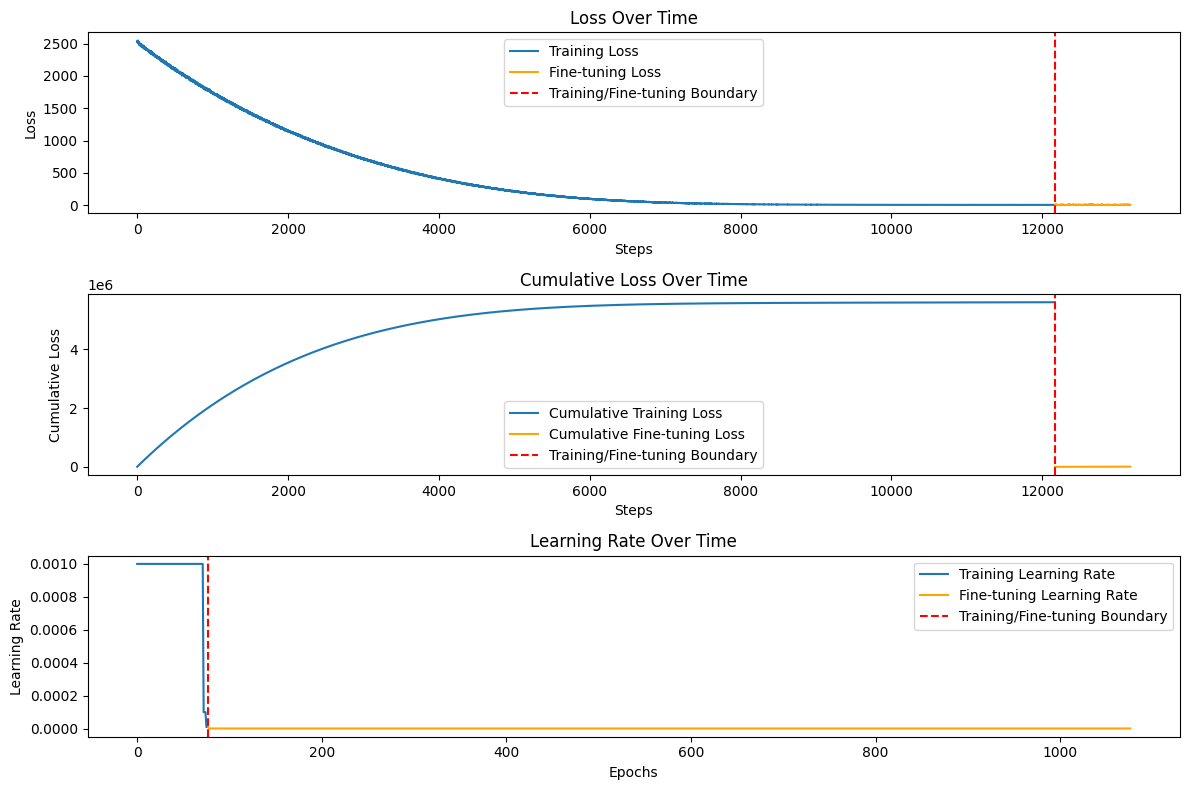

In [15]:
gnn_expert.plot_training_curves()  # 绘制训练曲线

Predicted values for t=50: [35.873867 45.74366  46.60917  42.04296  48.328518 54.117    68.652885
 51.74503  52.481586 49.253426]
True values for t=50: [37.979206 46.101223 46.028137 41.439808 47.125584 51.89477  71.41243
 51.108482 51.90689  50.92283 ]


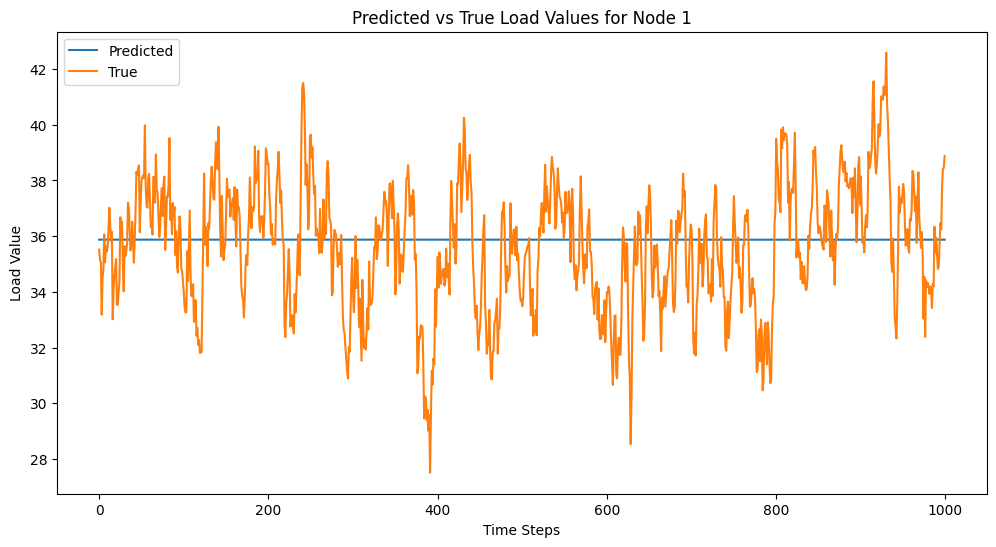

In [16]:
t = 50
predicted, true_value = gnn_expert.get_prediction_at_time(t)
print(f"Predicted values for t={t}: {predicted}")
print(f"True values for t={t}: {true_value}")
# 绘制预测与真实值对比图
gnn_expert.plot_results(gnn_expert.train_val_predictions, gnn_expert.true_values)